# Project 2: Topic Classification

*Completed by Andrew Walters in March 2018*

In this project, you'll work with text data from newsgroup postings on a variety of topics. You'll train classifiers to distinguish between the topics based on the text of the posts. Whereas with digit classification, the input is relatively dense: a 28x28 matrix of pixels, many of which are non-zero, here we'll represent each document with a "bag-of-words" model. As you'll see, this makes the feature representation quite sparse -- only a few words of the total vocabulary are active in any given document. The bag-of-words assumption here is that the label depends only on the words; their order is not important.

The SK-learn documentation on feature extraction will prove useful:
http://scikit-learn.org/stable/modules/feature_extraction.html

Each problem can be addressed succinctly with the included packages -- please don't add any more. Grading will be based on writing clean, commented code, along with a few short answers.

As always, you're welcome to work on the project in groups and discuss ideas on the course wall, but please prepare your own write-up and write your own code.

In [30]:
# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline

# General libraries.
import re
import numpy as np
import matplotlib.pyplot as plt

# SK-learn libraries for learning.
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.grid_search import GridSearchCV

# SK-learn libraries for evaluation.
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import classification_report

# SK-learn library for importing the newsgroup data.
from sklearn.datasets import fetch_20newsgroups

# SK-learn libraries for feature extraction from text.
from sklearn.feature_extraction.text import *

## STUDENT START ##
from IPython.display import display, Markdown, HTML
import pandas as pd
## STUDENT END ##

Load the data, stripping out metadata so that we learn classifiers that only use textual features. By default, newsgroups data is split into train and test sets. We further split the test so we have a dev set. Note that we specify 4 categories to use for this project. If you remove the categories argument from the fetch function, you'll get all 20 categories.

In [31]:
categories = ['alt.atheism', 'talk.religion.misc', 'comp.graphics', 'sci.space']
newsgroups_train = fetch_20newsgroups(subset='train',
                                      remove=('headers', 'footers', 'quotes'),
                                      categories=categories)
newsgroups_test = fetch_20newsgroups(subset='test',
                                     remove=('headers', 'footers', 'quotes'),
                                     categories=categories)

num_test = len(newsgroups_test.target)
half_num_test = int(num_test/2)
test_data, test_labels = newsgroups_test.data[half_num_test:], newsgroups_test.target[half_num_test:]
dev_data, dev_labels = newsgroups_test.data[:half_num_test], newsgroups_test.target[:half_num_test]
train_data, train_labels = newsgroups_train.data, newsgroups_train.target

print ('training label shape:', train_labels.shape)
print ('test label shape:', test_labels.shape)
print ('dev label shape:', dev_labels.shape)
print ('labels names:', newsgroups_train.target_names)

training label shape: (2034,)
test label shape: (677,)
dev label shape: (676,)
labels names: ['alt.atheism', 'comp.graphics', 'sci.space', 'talk.religion.misc']


## Problem 1

For each of the first 5 training examples, print the text of the message along with the label.

[2 pts]

In [32]:
def P1(num_examples=5):
    for ii in range(0,num_examples):
        
        disp_label = '**Training Example ' \
        + str(ii) \
        + ' is labeled ' \
        + newsgroups_train.target_names[train_labels[ii]] \
        + '**'
        display(Markdown(disp_label))
        display(Markdown(train_data[ii]))

P1(5)

**Training Example 0 is labeled comp.graphics**

Hi,

I've noticed that if you only save a model (with all your mapping planes
positioned carefully) to a .3DS file that when you reload it after restarting
3DS, they are given a default position and orientation.  But if you save
to a .PRJ file their positions/orientation are preserved.  Does anyone
know why this information is not stored in the .3DS file?  Nothing is
explicitly said in the manual about saving texture rules in the .PRJ file. 
I'd like to be able to read the texture rule information, does anyone have 
the format for the .PRJ file?

Is the .CEL file format available from somewhere?

Rych

**Training Example 1 is labeled talk.religion.misc**



Seems to be, barring evidence to the contrary, that Koresh was simply
another deranged fanatic who thought it neccessary to take a whole bunch of
folks with him, children and all, to satisfy his delusional mania. Jim
Jones, circa 1993.


Nope - fruitcakes like Koresh have been demonstrating such evil corruption
for centuries.

**Training Example 2 is labeled sci.space**


 >In article <1993Apr19.020359.26996@sq.sq.com>, msb@sq.sq.com (Mark Brader) 

MB>                                                             So the
MB> 1970 figure seems unlikely to actually be anything but a perijove.

JG>Sorry, _perijoves_...I'm not used to talking this language.

Couldn't we just say periapsis or apoapsis?

 

**Training Example 3 is labeled alt.atheism**

I have a request for those who would like to see Charley Wingate
respond to the "Charley Challenges" (and judging from my e-mail, there
appear to be quite a few of you.)  

It is clear that Mr. Wingate intends to continue to post tangential or
unrelated articles while ingoring the Challenges themselves.  Between
the last two re-postings of the Challenges, I noted perhaps a dozen or
more posts by Mr. Wingate, none of which answered a single Challenge.  

It seems unmistakable to me that Mr. Wingate hopes that the questions
will just go away, and he is doing his level best to change the
subject.  Given that this seems a rather common net.theist tactic, I
would like to suggest that we impress upon him our desire for answers,
in the following manner:

1. Ignore any future articles by Mr. Wingate that do not address the
Challenges, until he answers them or explictly announces that he
refuses to do so.

--or--

2. If you must respond to one of his articles, include within it
something similar to the following:

    "Please answer the questions posed to you in the Charley Challenges."

Really, I'm not looking to humiliate anyone here, I just want some
honest answers.  You wouldn't think that honesty would be too much to
ask from a devout Christian, would you?  

Nevermind, that was a rhetorical question.

**Training Example 4 is labeled sci.space**

AW&ST  had a brief blurb on a Manned Lunar Exploration confernce
May 7th  at Crystal City Virginia, under the auspices of AIAA.

Does anyone know more about this?  How much, to attend????

Anyone want to go?

## Problem 2

Use CountVectorizer to turn the raw training text into feature vectors. You should use the fit_transform function, which makes 2 passes through the data: first it computes the vocabulary ("fit"), second it converts the raw text into feature vectors using the vocabulary ("transform").

The vectorizer has a lot of options. To get familiar with some of them, write code to answer these questions:

a. The output of the transform (also of fit_transform) is a sparse matrix: http://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.sparse.csr_matrix.html. What is the size of the vocabulary? What is the average number of non-zero features per example? What fraction of the entries in the matrix are non-zero? Hint: use "nnz" and "shape" attributes.

b. What are the 0th and last feature strings (in alphabetical order)? Hint: use the vectorizer's get_feature_names function.

c. Specify your own vocabulary with 4 words: ["atheism", "graphics", "space", "religion"]. Confirm the training vectors are appropriately shaped. Now what's the average number of non-zero features per example?

d. Instead of extracting unigram word features, use "analyzer" and "ngram_range" to extract bigram and trigram character features. What size vocabulary does this yield?

e. Use the "min_df" argument to prune words that appear in fewer than 10 documents. What size vocabulary does this yield?

f. Using the standard CountVectorizer, what fraction of the words in the dev data are missing from the vocabulary? Hint: build a vocabulary for both train and dev and look at the size of the difference.

[6 pts]

In [4]:
def P2():
    
    # part a
    display(Markdown("**Part A**"))
    cv0 = CountVectorizer()
    train_data_sparse0 = cv0.fit_transform(train_data)
    print("Number of Words in Vocabulary: " + str(train_data_sparse0.shape[1]))
    print("Average Number of Features per Example: " \
          + str(train_data_sparse0.nnz/train_data_sparse0.shape[0]))
    print("Proportion of Datatset that is Non-Zero: " \
          + str(train_data_sparse0.nnz/(train_data_sparse0.shape[0]*train_data_sparse0.shape[1])))
    
    # part b
    display(Markdown("**Part B**"))
    print("The First Feature Alphabetically is: " \
          + cv0.get_feature_names()[0])
    print("The Last Feature Alphabetically is: " \
          + cv0.get_feature_names()[-1])
    
    # part c
    display(Markdown("**Part C**"))
    custom_dict = ["atheism", "graphics", "space", "religion"]
    cv1 = CountVectorizer(vocabulary=custom_dict)
    train_data_sparse1 = cv1.fit_transform(train_data)
    print("Number of Words in Vocabulary: " + str(train_data_sparse1.shape[1]))
    print("Average Number of Features per Example: " \
          + str(train_data_sparse1.nnz/train_data_sparse1.shape[0]))
    
    # part d
    display(Markdown("**Part D**"))
    cv2 = CountVectorizer(analyzer="char",ngram_range=(2,3))
    train_data_sparse2 = cv2.fit_transform(train_data)
    print("Number of Words in Vocabulary: " + str(train_data_sparse2.shape[1]))
    
    # part e
    display(Markdown("**Part E**"))
    cv3 = CountVectorizer(min_df=10)
    train_data_sparse3 = cv3.fit_transform(train_data)
    print("Number of Words in Vocabulary: " + str(train_data_sparse3.shape[1]))
    
    # part f
    display(Markdown("**Part F**"))
    cv4 = CountVectorizer()
    dev_data_sparse4 = cv4.fit_transform(dev_data)
    missing_words = list( set(cv4.get_feature_names()) - set(cv0.get_feature_names()) )
    print("Proportion of Missing Words in Dev Data: " \
          + str(len(missing_words)/dev_data_sparse4.shape[1]))
    
P2()

**Part A**

Number of Words in Vocabulary: 26879
Average Number of Features per Example: 96.70599803343165
Proportion of Datatset that is Non-Zero: 0.0035978272269590263


**Part B**

The First Feature Alphabetically is: 00
The Last Feature Alphabetically is: zyxel


**Part C**

Number of Words in Vocabulary: 4
Average Number of Features per Example: 0.26843657817109146


**Part D**

Number of Words in Vocabulary: 35478


**Part E**

Number of Words in Vocabulary: 3064


**Part F**

Proportion of Missing Words in Dev Data: 0.24787640034470024


## Problem 3

Use the default CountVectorizer options and report the f1 score (use metrics.f1_score) for a k nearest neighbors classifier; find the optimal value for k. Also fit a Multinomial Naive Bayes model and find the optimal value for alpha. Finally, fit a logistic regression model and find the optimal value for the regularization strength C using l2 regularization. A few questions:

a. Why doesn't nearest neighbors work well for this problem?

b. Any ideas why logistic regression doesn't work as well as Naive Bayes?

c. Logistic regression estimates a weight vector for each class, which you can access with the coef\_ attribute. Output the sum of the squared weight values for each class for each setting of the C parameter. Briefly explain the relationship between the sum and the value of C.

[4 pts]

In [5]:
def P3():
    # combine training and dev data into a singe cv dataset
    cv_data = train_data+dev_data
    cv_labels = np.concatenate([train_labels,dev_labels])

    # use count vectorizer to pre-process cv data
    count_vector_0 = CountVectorizer()
    cv_data_sparse0 = count_vector_0.fit_transform(cv_data)
    train_data_sparse0 = count_vector_0.fit_transform(train_data)
    dev_data_sparse0 = count_vector_0.transform(dev_data)

    # use grid search to estimate best knn classifier with cross validation data
    param_grid = {'n_neighbors': list(range(1,51))}
    grid_search = GridSearchCV(estimator=KNeighborsClassifier(),
                               param_grid=param_grid,
                               cv=5,
                               scoring='f1_macro')
    grid_search.fit(cv_data_sparse0,cv_labels)

    # create and train the best knn classifier with training data, test with dev
    best_knn = KNeighborsClassifier(n_neighbors=grid_search.best_params_['n_neighbors'])
    best_knn.fit(train_data_sparse0,train_labels)
    best_knn_predict = best_knn.predict(dev_data_sparse0)
    display(Markdown("**Classification Report for KNearestNeighbors with neighbors=" \
                     + str(grid_search.best_params_['n_neighbors']) \
                     + "**"))
    print(classification_report(dev_labels,best_knn_predict))

    # use grid search to estimate best multinomial naive bayes classifier with cross validation data
    param_grid = {'alpha': list(range(1,21))}
    grid_search = GridSearchCV(estimator=MultinomialNB(),
                               param_grid=param_grid,
                               cv=5,
                               scoring='f1_macro')
    grid_search.fit(cv_data_sparse0,cv_labels)

    # create and train the best mnb classifier with training data, test with dev
    best_mnb = MultinomialNB(alpha=grid_search.best_params_['alpha'])
    best_mnb.fit(train_data_sparse0,train_labels)
    best_mnb_predict = best_mnb.predict(dev_data_sparse0)
    display(Markdown("** Classification Report for MultinomialNaiveBayes with alpha=" \
                     + str(grid_search.best_params_['alpha']) \
                     + " **"))
    print(classification_report(dev_labels,best_mnb_predict))

    # use grid search to estimate best logistic regression classifier with cross validation data
    c_values = list(np.arange(0.2,5.0,0.2))
    param_grid = {'C': c_values}
    grid_search = GridSearchCV(estimator=LogisticRegression(),
                               param_grid=param_grid,
                               cv=5,
                               scoring='f1_macro')
    grid_search.fit(cv_data_sparse0,cv_labels)

    # create and train the best logistic classifier with training data, test with dev
    best_lgr = LogisticRegression(C=grid_search.best_params_['C'])
    best_lgr.fit(train_data_sparse0,train_labels)
    best_lgr_predict = best_lgr.predict(dev_data_sparse0)
    display(Markdown("** Classification Report for LogisticRegression with C=" \
                     + str(grid_search.best_params_['C']) \
                     + " **"))
    print(classification_report(dev_labels,best_lgr_predict))
    
       
P3()

**Classification Report for KNearestNeighbors with neighbors=13**

             precision    recall  f1-score   support

          0       0.36      0.46      0.40       165
          1       0.47      0.45      0.46       185
          2       0.55      0.48      0.51       199
          3       0.28      0.24      0.26       127

avg / total       0.43      0.42      0.42       676



** Classification Report for MultinomialNaiveBayes with alpha=1 **

             precision    recall  f1-score   support

          0       0.63      0.75      0.68       165
          1       0.92      0.91      0.92       185
          2       0.84      0.87      0.85       199
          3       0.68      0.50      0.58       127

avg / total       0.78      0.78      0.78       676



** Classification Report for LogisticRegression with C=0.6 **

             precision    recall  f1-score   support

          0       0.62      0.56      0.59       165
          1       0.81      0.88      0.84       185
          2       0.75      0.81      0.78       199
          3       0.61      0.54      0.57       127

avg / total       0.71      0.72      0.71       676



### ANSWER:

#### a. Why doesn't nearest neighbors work well for this problem?

Determining distance on a sparse matrix is difficult, and there is the added complexity that words in the english language do not have a standard "distance" from eachother. Consider two sentances that should both be categorized as christianity:

- Let's talk about Jesus.
- We're discussing God's son.

Knowledge of the english language allows us to understand that these sentances are discussing the same thing, but nearest neighbors would consider the distance to be just as far apart as an unrelated 4 word sentance.

#### b. Any ideas why logistic regression doesn't work as well as Naive Bayes?

Naive bayes treats each feature as conditionally independant, while logistic regression models correlations among features. Since text data is highly complex (the set of all possible valid sentances given the english dictionary is enormous) it could be difficult to model the correlations with a smaller dataset (~2000 samples). Logistic regression will perform better with more training data, but naive bayes will always have the independace assumption bias regardless of dataset size. [Quora](https://www.quora.com/What-is-the-difference-between-logistic-regression-and-Naive-Bayes)

#### c. Logistic regression estimates a weight vector for each class, which you can access with the coef\_ attribute. Output the sum of the squared weight values for each class for each setting of the C parameter. Briefly explain the relationship between the sum and the value of C.


## Problem 4

Train a logistic regression model. Find the 5 features with the largest weights for each label -- 20 features in total. Create a table with 20 rows and 4 columns that shows the weight for each of these features for each of the labels. Create the table again with bigram features. Any surprising features in this table?

[5 pts]

In [8]:
def P4():

    # constant
    num_coefs = 5
    best_c = 0.6
    
    # use count vectorizer to pre-process cv data
    count_vector_multi = CountVectorizer()
    train_data_sparse_muti = count_vector_multi.fit_transform(train_data)
    dev_data_sparse_multi = count_vector_multi.transform(dev_data)

    # create and train a multinomial logistic regression classifier
    mlr = LogisticRegression(C=best_c)
    mlr = mlr.fit(train_data_sparse_muti,train_labels)

    # find the largest coeficients for each label
    large_coefs_mlr = {}
    for ii in range(0,len(newsgroups_train.target_names)):
        large_coefs_mlr[newsgroups_train.target_names[ii]] = []
        index = np.argsort(mlr.coef_[ii])[-num_coefs:]
        for jj in index:
            large_coefs_mlr[newsgroups_train.target_names[ii]].append(count_vector_multi.get_feature_names()[jj])

    # display the 5 highest weighted features, use pandas to easily display as a table
    display(Markdown("**Highest Weighted Features for Each Category for Count Vectorizer**"))
    display(HTML(pd.DataFrame(large_coefs_mlr).to_html()))
    
    # use count vectorizer to pre-process cv data
    count_vector_binary = CountVectorizer(binary=True)
    train_data_sparse_binary = count_vector_binary.fit_transform(train_data)
    dev_data_sparse_binary = count_vector_binary.transform(dev_data)

    # create and train a multinomial logistic regression classifier
    blr = LogisticRegression()
    blr = blr.fit(train_data_sparse_binary,train_labels)

    # find the largest coeficients for each label
    large_coefs_blr = {}
    for ii in range(0,len(newsgroups_train.target_names)):
        large_coefs_blr[newsgroups_train.target_names[ii]] = []
        index = np.argsort(blr.coef_[ii])[-num_coefs:]
        for jj in index:
            large_coefs_blr[newsgroups_train.target_names[ii]].append(count_vector_binary.get_feature_names()[jj])

    # display the 5 highest weighted features, use pandas to easily display as a table
    display(Markdown("**Highest Weighted Features for Each Category for Binary Count Vectorizer**"))
    display(HTML(pd.DataFrame(large_coefs_blr).to_html()))

P4()

**Highest Weighted Features for Each Category for Count Vectorizer**

,alt.atheism,comp.graphics,sci.space,talk.religion.misc
0,deletion,computer,spacecraft,order
1,atheism,3d,launch,fbi
2,religion,file,nasa,blood
3,bobby,image,orbit,christian
4,atheists,graphics,space,christians


**Highest Weighted Features for Each Category for Binary Count Vectorizer**

,alt.atheism,comp.graphics,sci.space,talk.religion.misc
0,religion,hi,spacecraft,god
1,bobby,3d,launch,order
2,atheists,image,nasa,fbi
3,atheism,file,orbit,christian
4,deletion,graphics,space,christians


### ANSWER:
The only suprising difference is in the category comp.graphics where the binary features has "hi" as a top 5 feature, replacing "computer" from the default count vectorizer model. While it is not clear why "hi" would be used more in discussion of graphics than any other category, it does makes sense that if it was it would only appear in a bigram feature model. "hi" would rarely be used more than once per post, so it would be overshadowed by more commonly repeated words if word count was considered.

## Problem 5

Try to improve the logistic regression classifier by passing a custom preprocessor to CountVectorizer. The preprocessing function runs on the raw text, before it is split into words by the tokenizer. Your preprocessor should try to normalize the input in various ways to improve generalization. For example, try lowercasing everything, replacing sequences of numbers with a single token, removing various other non-letter characters, and shortening long words. If you're not already familiar with regular expressions for manipulating strings, see https://docs.python.org/2/library/re.html, and re.sub() in particular. With your new preprocessor, how much did you reduce the size of the dictionary?

For reference, I was able to improve dev F1 by 2 points.

[4 pts]

In [9]:
def better_preprocessor(s):
    # remove all characters other than whitespace and alphanumerics
    s = re.sub(r"[^\w\s]",'',s)
    # replace any word containing a number
    s = re.sub(r'\w*\d\w*','preprocessor_replaced_number',s)
    # make every letter lowercase
    s = s.lower()
    return s

In [41]:
def P5():
    
    # constant
    best_c = 0.6
    
    # use count vectorizer without pre processing
    count_vector_none = CountVectorizer()
    train_data_sparse_none = count_vector_none.fit_transform(train_data)
    
    # use count vectorizer to pre-process cv data
    count_vector_prepro = CountVectorizer(preprocessor=better_preprocessor)
    train_data_sparse_prepro = count_vector_prepro.fit_transform(train_data)
    dev_data_sparse_prepro = count_vector_prepro.transform(dev_data)

    # print vocabulary reduction
    print("Reduced Vocabulary from " \
          + str(train_data_sparse_none.shape[1]) \
          + " features to " \
          + str(train_data_sparse_prepro.shape[1]) \
          + " features")

    # create multinomial logistic regression classifier with preprocessed data
    mlrp = LogisticRegression(C=best_c)
    mlrp = mlrp.fit(train_data_sparse_prepro,train_labels)
    mlrp_predict = mlrp.predict(dev_data_sparse_prepro)
    display(Markdown("** Classification Report for PreProcessed Logistic Regression **"))
    print(classification_report(dev_labels,mlrp_predict))

P5()

Reduced Vocabulary from 26879 features to 26599 features


** Classification Report for PreProcessed Logistic Regression **

             precision    recall  f1-score   support

          0       0.64      0.56      0.60       165
          1       0.71      0.89      0.79       185
          2       0.77      0.75      0.76       199
          3       0.60      0.50      0.55       127

avg / total       0.69      0.70      0.69       676



## Problem 6

The idea of regularization is to avoid learning very large weights (which are likely to fit the training data, but not generalize well) by adding a penalty to the total size of the learned weights. That is, logistic regression seeks the set of weights that minimizes errors in the training data AND has a small size. The default regularization, L2, computes this size as the sum of the squared weights (see P3, above). L1 regularization computes this size as the sum of the absolute values of the weights. The result is that whereas L2 regularization makes all the weights relatively small, L1 regularization drives lots of the weights to 0, effectively removing unimportant features.

Train a logistic regression model using a "l1" penalty. Output the number of learned weights that are not equal to zero. How does this compare to the number of non-zero weights you get with "l2"? Now, reduce the size of the vocabulary by keeping only those features that have at least one non-zero weight and retrain a model using "l2".

Make a plot showing accuracy of the re-trained model vs. the vocabulary size you get when pruning unused features by adjusting the C parameter.

Note: The gradient descent code that trains the logistic regression model sometimes has trouble converging with extreme settings of the C parameter. Relax the convergence criteria by setting tol=.01 (the default is .0001).

[4 pts]

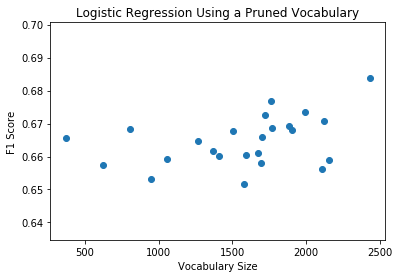

In [39]:
def P6():
    
    # Keep this random seed here to make comparison easier.
    np.random.seed(0)
    
    # use count vectorizer to create sparse data
    count_vector_L1 = CountVectorizer()
    train_data_sparse_L1 = count_vector_L1.fit_transform(train_data)
    dev_data_sparse_L1 = count_vector_L1.transform(dev_data)
    
    # initialize container for graph points
    vocabs = []
    f1s = []
    
    for c in list(np.arange(0.2,5.0,0.2)):

        # create and train a multinomial logistic regression classifier
        L1lr = LogisticRegression(penalty='l1',C=c,tol=0.01)
        L1lr = L1lr.fit(train_data_sparse_L1,train_labels)

        # define a vocabulary by finding all features where the weight from L1lr is 0 for each category
        sum_L1_coef = L1lr.coef_.sum(axis=0)
        L1_feature_names = np.array(count_vector_L1.get_feature_names())
        L1_feature_names = L1_feature_names[sum_L1_coef!=0]

        # use count vectorizer with the pruned vocabulary
        count_vector_L2 = CountVectorizer(vocabulary=L1_feature_names)
        train_data_sparse_L2 = count_vector_L2.fit_transform(train_data)
        dev_data_sparse_L2 = count_vector_L2.transform(dev_data)

        # create and train a multinomial logistic regression classifier with pruned vocabulary data
        L2lr = LogisticRegression(penalty='l2',C=c,tol=0.01)
        L2lr = L2lr.fit(train_data_sparse_L2,train_labels)

        # display classification report for pruned classifier
        L2lr_predict = L2lr.predict(dev_data_sparse_L2)
        
        # save data points
        vocabs.append(len(L1_feature_names))
        f1s.append(metrics.f1_score(dev_labels,L2lr_predict,average='macro'))
    
    # visualize f1 as a function of vocabulary size
    ax = plt.scatter(vocabs,f1s)
    plt.title("Logistic Regression Using a Pruned Vocabulary")
    plt.xlabel("Vocabulary Size")
    plt.ylabel("F1 Score")

P6()

## Problem 7

Use the TfidfVectorizer -- how is this different from the CountVectorizer? Train a logistic regression model with C=100.

Make predictions on the dev data and show the top 3 documents where the ratio R is largest, where R is:

maximum predicted probability / predicted probability of the correct label

What kinds of mistakes is the model making? Suggest a way to address one particular issue that you see.

[4 pts]

In [21]:
def P7():

    # constants
    num_examples = 3
    c = 100

    # use count vectorizer to process training and dev data
    tfid_vector = TfidfVectorizer()
    train_data_tfid = tfid_vector.fit_transform(train_data)
    dev_data_tfid = tfid_vector.transform(dev_data)

    # create and train a multinomial logistic regression classifier with tfidfvectorizer data
    tfidlr = LogisticRegression(C=c)
    tfidlr = tfidlr.fit(train_data_tfid,train_labels)
    tfidlr_predict = tfidlr.predict(dev_data_tfid)
    tfidlr_predict_proba = tfidlr.predict_proba(dev_data_tfid)
    
    # display classification report
    display(Markdown("**Classification Report for Logistic Regression Using TfidfVectorizer**"))
    print(classification_report(dev_labels,tfidlr_predict))

    # find the probability of the predicted label
    tfidlr_max_proba = np.amax(tfidlr_predict_proba,axis=1)
    
    # find the probability of the correct label
    tfidlr_correct_proba = []
    for ii in range(len(dev_labels)):
        tfidlr_correct_proba.append(tfidlr_predict_proba[ii][dev_labels[ii]])

    # determine the r ratio
    r_ratio = tfidlr_max_proba/tfidlr_correct_proba

    r_index = np.argsort(r_ratio)[-num_examples:]
    for ii in r_index:
        disp_label = '**Dev Example ' \
        + str(ii) \
        + ' is labeled ' \
        + newsgroups_train.target_names[train_labels[ii]] \
        + ' with r-ratio=' \
        + str(r_ratio[ii]) \
        + '**'
        display(Markdown(disp_label))
        display(Markdown(dev_data[ii]))

P7()

**Classification Report for Logistic Regression Using TfidfVectorizer**

             precision    recall  f1-score   support

          0       0.69      0.62      0.65       165
          1       0.80      0.91      0.85       185
          2       0.83      0.83      0.83       199
          3       0.68      0.64      0.66       127

avg / total       0.76      0.76      0.76       676



**Dev Example 607 is labeled talk.religion.misc with r-ratio=287.1791926**


The 24 children were, of course, killed by a lone gunman in a second story
window, who fired eight bullets in the space of two seconds...


**Dev Example 665 is labeled comp.graphics with r-ratio=325.004068404**

Can anyone provide me a ftp site where I can obtain a online version
of the Book of Mormon. Please email the internet address if possible.

**Dev Example 215 is labeled comp.graphics with r-ratio=929.358058619**

I am pleased to announce that a *revised version* of _The Easy-to-Read Book
of Mormon_ (former title: _Mormon's Book_) by Lynn Matthews Anderson is now
available through anonymous ftp (see information below). In addition to the
change in title, the revised ETR BOM has been shortened by several pages
(eliminating many extraneous "that's" and "of's"), and many (minor) errors
have been corrected. This release includes a simplified Joseph Smith Story,
testimonies of the three and eight witnesses, and a "Words-to-Know"
glossary.

As with the previous announcement, readers are reminded that this is a
not-for-profit endeavor. This is a copyrighted work, but people are welcome
to make *verbatim* copies for personal use. People can recuperate the
actual costs of printing (paper, copy center charges), but may not charge
anything for their time in making copies, or in any way realize a profit
from the use of this book. See the permissions notice in the book itself
for the precise terms.

Negotiations are currently underway with a Mormon publisher vis-a-vis the
printing and distribution of bound books. (Sorry, I'm out of the wire-bound
"first editions.") I will make another announcement about the availability
of printed copies once everything has been worked out.

FTP information: connect via anonymous ftp to carnot.itc.cmu.edu, then "cd
pub" (you won't see anything at all until you do).

"The Easy-to-Read Book of Mormon" is currently available in postscript and
RTF (rich text format). (ASCII, LaTeX, and other versions can be made
available; contact dba@andrew.cmu.edu for details.) You should be able to
print the postscript file on any postscript printer (such as an Apple
Laserwriter); let dba know if you have any difficulties. (The postscript in
the last release had problems on some printers; this time it should work
better.) RTF is a standard document interchange format that can be read in
by a number of word processors, including Microsoft Word for both the
Macintosh and Windows. If you don't have a postscript printer, you may be
able to use the RTF file to print out a copy of the book.

-r--r--r--  1 dba                   1984742 Apr 27 13:12 etrbom.ps
-r--r--r--  1 dba                   1209071 Apr 27 13:13 etrbom.rtf

For more information about how this project came about, please refer to my
article in the current issue of _Sunstone_, entitled "Delighting in
Plainness: Issues Surrounding a Simple Modern English Book of Mormon."

Send all inquiries and comments to:

    Lynn Matthews Anderson
    5806 Hampton Street
    Pittsburgh, PA 15206

### ANSWER:
The use of computer jargon in otherwise religious posts seems to confuse the classifier. For example "ftp" is used in both example 665 and 215 is one reason these might have been misclassified. One possible solution to this is to find the highest weighted features in the examples with high r ratios and prune those features.

## Problem 8 (Extra Credit)

Try implementing one of your ideas based on your error analysis. Use logistic regression as your underlying model.

- [1 pt] for a reasonable attempt
- [2 pts] for improved performance